# Taking Actions

Once we have a model that estimates transmission rate, we can predict the missing rates and simulate some actions to reduce the virus spread velocity in our whole population.

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings
from sklearn.inspection import permutation_importance

# Own
import predict

In [2]:
# Configurations
np.random.seed(1)
warnings.filterwarnings('ignore')

In [3]:
# Global variables
DATASETS_PATH = '../datasets/processed'
MODELS_PATH = '../models'
MODEL_SELECTED = 'mlp'

In [4]:
# Load datasets
connections = pd.read_csv(f'{DATASETS_PATH}/dataframe_modeling.csv')
connections = connections.drop('had_nan', axis=1)
connections.head()

,infecting,infected,proximity,transmission_rate,age_infecting,n_children_infecting,study_infecting,work_infecting,play_sports_infecting,body_mass_index_infecting,...,transportation_infecting_taxi,marital_status_infected_divorced,marital_status_infected_married,marital_status_infected_single,marital_status_infected_widow,transportation_infected_private,transportation_infected_public,transportation_infected_taxi,health_infecting,health_infected
0,1,2,2,0.589462,3.806662,1.0,1.0,0.0,1.0,33.033742,...,0,0,1,0,0,0,1,0,8.677875,10.304069
1,1,3,0,0.708465,3.806662,1.0,1.0,0.0,1.0,33.033742,...,0,0,0,1,0,1,0,0,8.677875,9.188442
2,2,4,1,0.659483,3.218876,0.0,0.0,0.0,1.0,33.167517,...,0,0,1,0,0,0,1,0,10.304069,8.448866
3,2,5,0,0.638842,3.218876,0.0,0.0,0.0,1.0,33.167517,...,0,0,0,1,0,0,1,0,10.304069,9.511152
4,3,6,3,0.343776,3.583519,1.0,0.0,0.0,1.0,32.926955,...,0,0,0,1,0,0,1,0,9.188442,10.822642


In [5]:
# Load model
with open(f'{MODELS_PATH}/{MODEL_SELECTED}.pkl', 'rb') as file:
    model = pickle.load(file)['model']
with open(f'{MODELS_PATH}/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

## 1. Complete Connections

New connections will be added to the dataset since if A connects to B, B also connects to A.

In [6]:
# Reverse dataset
connections_reverse = connections.copy()

MAP = {
    'age_infecting': 'age_infected',
    'n_children_infecting': 'n_children_infected',
    'study_infecting': 'study_infected',
    'work_infecting': 'work_infected',
    'play_sports_infecting': 'play_sports_infected',
    'body_mass_index_infecting': 'body_mass_index_infected',
    'marital_status_infecting_divorced': 'marital_status_infected_divorced',
    'marital_status_infecting_married': 'marital_status_infected_married',
    'marital_status_infecting_single': 'marital_status_infected_single',
    'marital_status_infecting_widow': 'marital_status_infected_widow',
    'transportation_infecting_private': 'transportation_infected_private',
    'transportation_infecting_public': 'transportation_infected_public',
    'transportation_infecting_taxi': 'transportation_infected_taxi',
    'infecting': 'infected'
}
for feature_1, feature_2 in MAP.items():
    connections_reverse[feature_1] = connections[feature_2]
    connections_reverse[feature_2] = connections[feature_1]

In [7]:
# Drop features
DROP_FEATURES = [
    'transportation_infected_public',
    'transportation_infecting_public',
    'age_infecting',
    'age_infected',
    'transmission_rate',
    'infecting',
    'infected',
    'degree_work',
    'degree_friends',
    'study_infected',
    'play_sports_infected',
    'work_infected',
    'marital_status_infected_married',
    'marital_status_infected_divorced',
    'marital_status_infected_single',
    'marital_status_infected_widow',
    'transportation_infected_taxi'
]

infecting = connections_reverse['infecting']
infected = connections_reverse['infected']
connections_reverse = connections_reverse.drop(DROP_FEATURES, axis=1)

In [8]:
# Recompute transmission rate
connections_reverse_norm = scaler.transform(connections_reverse)
y_reverse = predict.run(connections_reverse_norm, MODEL_SELECTED)

connections_reverse['transmission_rate'] = y_reverse
connections_reverse['infecting'] = infecting
connections_reverse['infected'] = infected

In [9]:
# Update dataset
connections_updated = pd.concat([connections, connections_reverse])
connections_updated = connections_updated.drop_duplicates(subset=['infecting', 'infected'])
connections_updated = connections_updated.reset_index(drop=True)
connections_updated

,infecting,infected,proximity,transmission_rate,age_infecting,n_children_infecting,study_infecting,work_infecting,play_sports_infecting,body_mass_index_infecting,...,transportation_infecting_taxi,marital_status_infected_divorced,marital_status_infected_married,marital_status_infected_single,marital_status_infected_widow,transportation_infected_private,transportation_infected_public,transportation_infected_taxi,health_infecting,health_infected
0,1,2,2,0.589462,3.806662,1.0,1.0,0.0,1.0,33.033742,...,0,0.0,1.0,0.0,0.0,0,1.0,0.0,8.677875,10.304069
1,1,3,0,0.708465,3.806662,1.0,1.0,0.0,1.0,33.033742,...,0,0.0,0.0,1.0,0.0,1,0.0,0.0,8.677875,9.188442
2,2,4,1,0.659483,3.218876,0.0,0.0,0.0,1.0,33.167517,...,0,0.0,1.0,0.0,0.0,0,1.0,0.0,10.304069,8.448866
3,2,5,0,0.638842,3.218876,0.0,0.0,0.0,1.0,33.167517,...,0,0.0,0.0,1.0,0.0,0,1.0,0.0,10.304069,9.511152
4,3,6,3,0.343776,3.583519,1.0,0.0,0.0,1.0,32.926955,...,0,0.0,0.0,1.0,0.0,0,1.0,0.0,9.188442,10.822642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999993,999996,499998,0,0.531675,NaN,1.0,0.0,1.0,1.0,30.496461,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,10.391996,8.577630
1999994,999997,499998,0,0.298490,NaN,1.0,0.0,1.0,1.0,33.146400,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,10.391996,8.925746
1999995,999998,499999,1,0.389472,NaN,1.0,0.0,0.0,1.0,32.973318,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,9.984192,9.602050
1999996,999999,499999,0,0.210860,NaN,0.0,1.0,1.0,1.0,32.765617,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,9.984192,9.291624


## 2. Feature's Impact

Let's understand how features impact on the transmission.

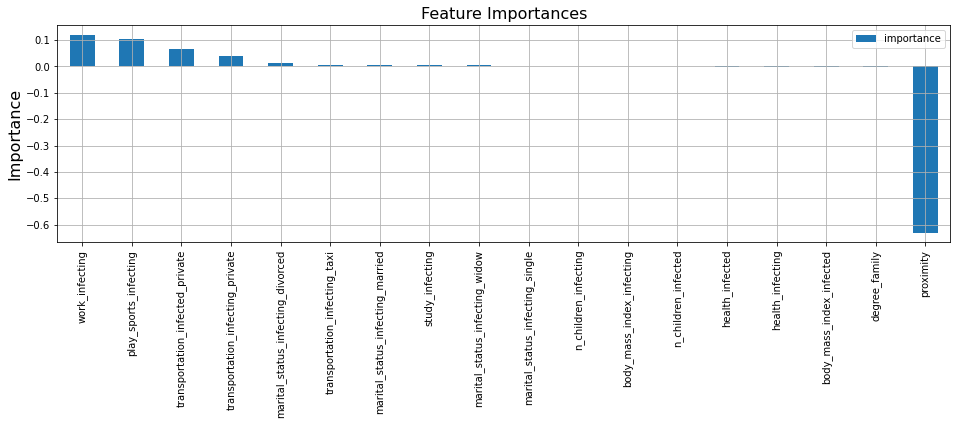

CPU times: user 5min 30s, sys: 2min 59s, total: 8min 29s
Wall time: 8min 38s


In [10]:
%%time

# Feature importance
x = connections_updated.drop(DROP_FEATURES, axis=1)
y = connections_updated['transmission_rate']

results = permutation_importance(
    model, x, y, scoring='neg_mean_squared_error', random_state=1)

importances = pd.Series(results.importances_mean, index=x.columns)
importances = importances.sort_values(ascending=False)
importances = importances / importances.apply(abs).sum()

plt.subplots(figsize=(16, 4))
importances.plot(kind='bar', label='importance')
plt.title('Feature Importances', size=16)
plt.ylabel('Importance', size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

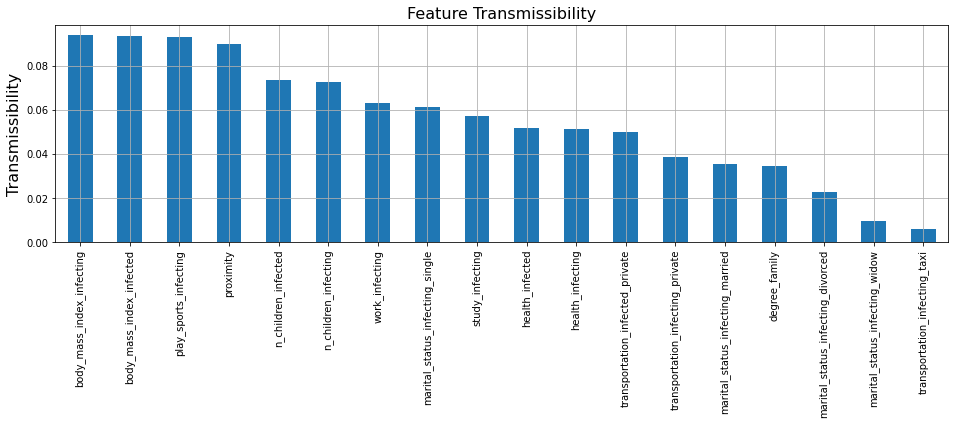

In [11]:
# Compute transmissibility

# FORMULA: transmissibility = mean transmission rate * connections with the feature

transmissibility = importances.copy()
for feature in transmissibility.index:
    feature_mean = connections_updated[feature].mean()
    connections_with_feature = connections_updated[connections_updated[feature] >= feature_mean]
    transmission_rate_mean = connections_with_feature['transmission_rate'].mean()
    n_connections_with_feature = len(connections_with_feature)
    transmissibility[feature] = transmission_rate_mean * n_connections_with_feature

plt.figure(figsize=(16, 4))
transmissibility = transmissibility.sort_values(ascending=False)
transmissibility = transmissibility / transmissibility.sum()
transmissibility.plot(kind='bar')
plt.title('Feature Transmissibility', size=16)
plt.ylabel('Transmissibility', size=16)
plt.grid()
plt.show()

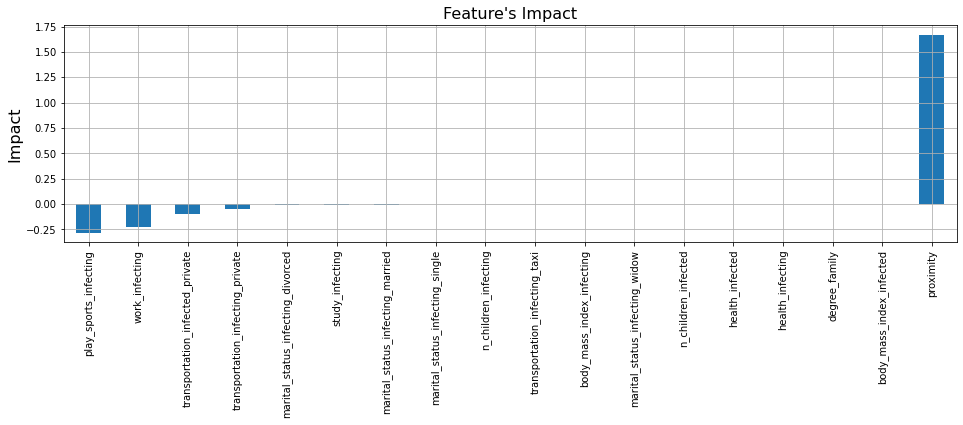

In [12]:
# Compute impact
feature_impact = importances * transmissibility
feature_impact = feature_impact.sort_values(ascending=False)
feature_impact = feature_impact / feature_impact.sum()

plt.figure(figsize=(16, 4))
feature_impact.plot(kind='bar')
plt.title("Feature's Impact", size=16)
plt.ylabel('Impact', size=16)
plt.grid()
plt.show()

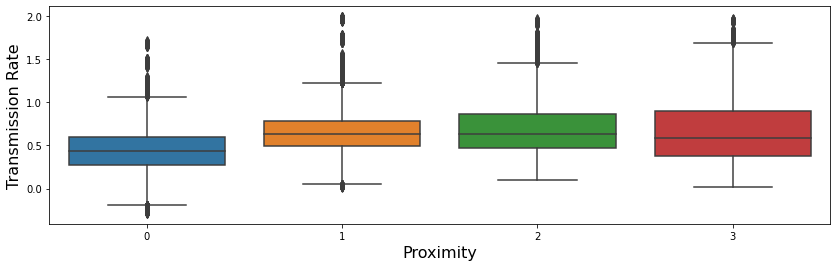

In [13]:
# How proximity affects the transmission rate?
plt.figure(figsize=(14, 4))
sns.boxplot(x='proximity', y='transmission_rate', data=connections_updated)
plt.xlabel('Proximity', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

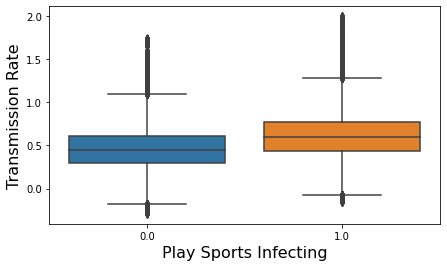

In [14]:
# How sports affect the transmission rate?
plt.figure(figsize=(7, 4))
sns.boxplot(x='play_sports_infecting', y='transmission_rate', data=connections_updated)
plt.xlabel('Play Sports Infecting', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

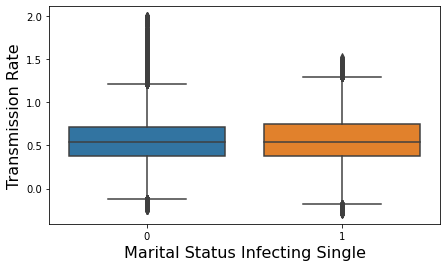

In [15]:
# How being single affects the transmission rate?
plt.figure(figsize=(7, 4))
sns.boxplot(x='marital_status_infecting_single', y='transmission_rate', data=connections_updated)
plt.xlabel('Marital Status Infecting Single', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

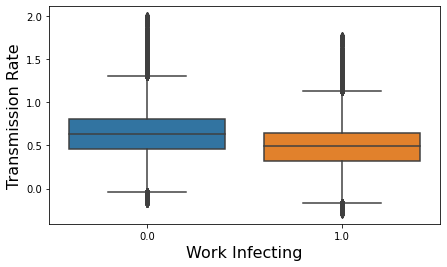

In [16]:
# How work affects the transmission rate?
plt.figure(figsize=(7, 4))
sns.boxplot(x='work_infecting', y='transmission_rate', data=connections_updated)
plt.xlabel('Work Infecting', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

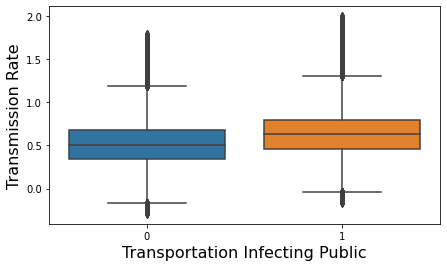

In [17]:
# How public transportation affects the transmission rate?
plt.figure(figsize=(7, 4))
sns.boxplot(x='transportation_infected_private', y='transmission_rate', data=connections_updated)
plt.xlabel('Transportation Infecting Public', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

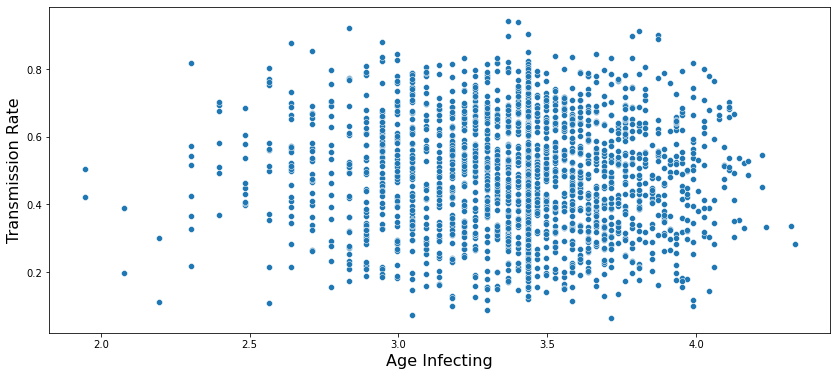

In [18]:
# How age affects the transmission rate?
plt.figure(figsize=(14, 6))
sns.scatterplot(x='age_infected', y='transmission_rate', data=connections_updated.iloc[0:2000])
plt.xlabel('Age Infecting', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

## 3. Running Simulations

Now we can simulate actions and understand what would be the epidemic contamination curve to see its impact.

In [19]:
# Contamination function

# FORMULA: N = SI (SI epidemic model)

RUNS = 1
N_FIRST_INFECTED = 100
STEPS = 30
def compute_contamination_curve(connections):

    infecting = connections[['infecting']]
    infected = connections[['infected']]
    connections_size = len(connections)
    max_ids = len(set(
        connections['infecting'].tolist() + connections['infected'].tolist()))

    # Runs
    contamination_curve_list = []
    for _ in range(RUNS):

        # Initiate with no infections
        infecting['status'] = 0
        infected['status'] = 0

        # First infected
        first_infected = infecting['infecting'].values
        np.random.shuffle(first_infected)
        first_infected = first_infected[:N_FIRST_INFECTED]
        infecting['status'] = np.where(infecting['infecting'].isin(first_infected), 1, 0)
        infected['status'] = np.where(infected['infected'].isin(first_infected), 1, 0)
        
        # Steps
        contamination_curve = [N_FIRST_INFECTED/max_ids]
        for _ in range(STEPS):

            # Compute new infected
            probabilities = np.random.uniform(size=(connections_size))
            condition = (
                (connections['transmission_rate'] >= probabilities) &
                (infecting['status'] == 1) &
                (infected['status'] == 0)
            )
            new_infected = infected['infected'][condition]

            # Update infected
            infecting['status'] = np.where(infecting['infecting'].isin(new_infected), 1, infecting['status'])
            infected['status'] = np.where(infected['infected'].isin(new_infected), 1, infected['status'])
            
            # Append contamination
            current_ids = len(np.unique(
                infecting['infecting'][infecting['status'] == 1].tolist() +
                infected['infected'][infected['status'] == 1].tolist()
            ))
            contamination_curve.append(current_ids / max_ids)

        contamination_curve_list.append(contamination_curve)

    contamination_curve_list = np.array(contamination_curve_list)
    contamination_curve_mean = contamination_curve_list.mean(axis=0)
    contamination_curve_std = contamination_curve_list.std(axis=0)

    return contamination_curve_mean, contamination_curve_std

In [20]:
# Maximum spread velocity

# FORMULA: max(t0 - t7)

def compute_max_spread_velocity(contamination_curve):
    dataframe = pd.DataFrame({'t0': contamination_curve})
    dataframe['t-7'] = dataframe.shift(7)
    dataframe['spread'] = dataframe['t0'] - dataframe['t-7']
    max_spread = dataframe['spread'].max()
    index = dataframe[dataframe['spread'] == max_spread].index[0]
    return max_spread, index

In [21]:
# Plot function
def plot_contamination_curve(dict_of_curves):
    plt.figure(figsize=(14, 5))
    for label, item in dict_of_curves.items():
        mean = item['mean']
        std = item['std']
        size = range(len(mean))
        plt.fill_between(size, mean - std, mean + std, alpha=0.1)
        plt.plot(size, mean, label=f'{label}')
    plt.title('Contamination Curves', size=16)
    plt.ylabel('Infected Population (%)', size=16)
    plt.xlabel('Time', size=16)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [22]:
# Initiate dictionary of plots
dict_of_curves = {}

In [23]:
# Baseline curve
baseline_mean, baseline_std = compute_contamination_curve(connections_updated)
baseline_spread_velocity, baseline_spread_index = compute_max_spread_velocity(baseline_mean)
dict_of_curves['baseline'] = {
    'mean': baseline_mean,
    'std': baseline_std,
    'velocity': baseline_spread_velocity,
    'index': baseline_spread_index
}

In [24]:
# What if we could reduce the transmission rate by 70% using mask?
connections_mask = connections_updated.copy()
connections_mask['transmission_rate'] = np.where(
    np.random.uniform(size=len(connections_updated)) > 0.2,  # How effective I believe we can be
    connections_mask['transmission_rate'] * 0.3,
    connections_mask['transmission_rate']
)
mask_mean, mask_std = compute_contamination_curve(connections_mask)
mask_spread_velocity, mask_spread_index = compute_max_spread_velocity(mask_mean)
dict_of_curves['mask'] = {
    'mean': mask_mean,
    'std': mask_std,
    'velocity': mask_spread_velocity,
    'index': mask_spread_index
}

In [27]:
# What if we limited our proximity?
connections_proximity = connections_updated.copy()

# select IDs
ids = connections_proximity['infecting'].unique()
n_ids = int(len(ids) * 0.8) # How effective I believe we can be
np.random.shuffle(ids)
selected_ids = ids[:n_ids]

# replace IDs
connections_proximity['proximity'] = np.where(
    connections_proximity['infecting'].isin(selected_ids), 0, connections_proximity['proximity']
)
connections_proximity['proximity'] = np.where(
    connections_proximity['infected'].isin(selected_ids), 0, connections_proximity['proximity']
)

# recompute transmission rate
connections_proximity_norm = scaler.transform(connections_proximity.drop(DROP_FEATURES, axis=1))
y_sports = predict.run(connections_proximity_norm, MODEL_SELECTED)
connections_proximity['transmission_rate'] = y_sports

# compute contamination curve
proximity_mean, proximity_std = compute_contamination_curve(connections_proximity)
proximity_spread_velocity, proximity_spread_index = compute_max_spread_velocity(proximity_mean)
dict_of_curves['proximity'] = {
    'mean': proximity_mean,
    'std': proximity_std,
    'velocity': proximity_spread_velocity,
    'index': proximity_spread_index
}

In [28]:
# What if we make everyone to stop doing sports?
connections_sports = connections_updated.copy()

# select IDs
ids = connections_sports['infecting'].unique()
n_ids = int(len(ids) * 0.8) # How effective I believe we can be
np.random.shuffle(ids)
selected_ids = ids[:n_ids]

# replace IDs
connections_sports['play_sports_infecting'] = np.where(
    connections_sports['infecting'].isin(selected_ids), 0, connections_sports['play_sports_infecting']
)
connections_sports['play_sports_infected'] = np.where(
    connections_sports['infected'].isin(selected_ids), 0, connections_sports['play_sports_infected']
)

# recompute transmission rate
connections_sports_norm = scaler.transform(connections_sports.drop(DROP_FEATURES, axis=1))
y_sports = predict.run(connections_sports_norm, MODEL_SELECTED)
connections_sports['transmission_rate'] = y_sports

# compute contamination curve
sports_mean, sports_std = compute_contamination_curve(connections_sports)
sports_spread_velocity, sports_spread_index = compute_max_spread_velocity(sports_mean)
dict_of_curves['sports'] = {
    'mean': sports_mean,
    'std': sports_std,
    'velocity': sports_spread_velocity,
    'index': sports_spread_index
}

In [29]:
# What if we make everyone to use private transportation?
connections_private = connections_updated.copy()

# select IDs
ids = connections_private['infecting'].unique()
n_ids = int(len(ids) * 0.8) # How effective I believe we can be
np.random.shuffle(ids)
selected_ids = ids[:n_ids]

# replace IDs
connections_private['transportation_infecting_public'] = np.where(
    connections_private['infecting'].isin(selected_ids), 0, connections_private['transportation_infecting_public']
)
connections_private['transportation_infecting_taxi'] = np.where(
    connections_private['infecting'].isin(selected_ids), 1, connections_private['transportation_infecting_taxi']
)
connections_private['transportation_infecting_private'] = np.where(
    connections_private['infecting'].isin(selected_ids), 0, connections_private['transportation_infecting_private']
)
connections_private['transportation_infected_public'] = np.where(
    connections_private['infected'].isin(selected_ids), 0, connections_private['transportation_infected_public']
)
connections_private['transportation_infected_taxi'] = np.where(
    connections_private['infected'].isin(selected_ids), 1, connections_private['transportation_infected_taxi']
)
connections_private['transportation_infected_private'] = np.where(
    connections_private['infected'].isin(selected_ids), 0, connections_private['transportation_infected_private']
)

# recompute transmission rate
connections_private_norm = scaler.transform(connections_private.drop(DROP_FEATURES, axis=1))
y_private = predict.run(connections_private_norm, MODEL_SELECTED)
connections_private['transmission_rate'] = y_private

# compute contamination curve
private_mean, private_std = compute_contamination_curve(connections_private)
private_spread_velocity, private_spread_index = compute_max_spread_velocity(private_mean)
dict_of_curves['private'] = {
    'mean': private_mean,
    'std': private_std,
    'velocity': private_spread_velocity,
    'index': private_spread_index
}

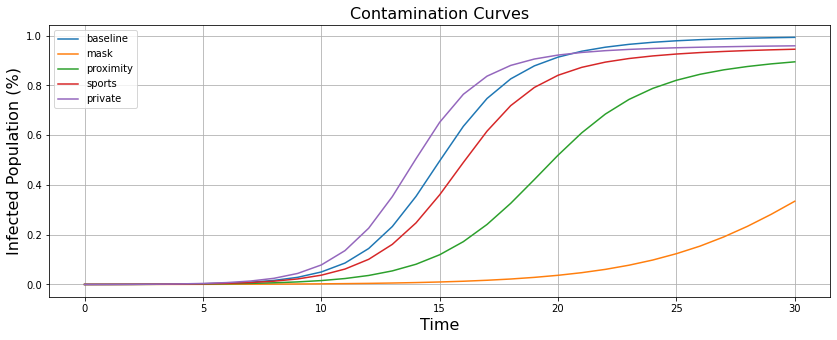

In [30]:
# Plot contamination curve
plot_contamination_curve(dict_of_curves)

**Observations:**
- this is an SI epidemic, it means that there's no cure, so no one recovers
- the problem doesn't state if the virus can kill, so it wasn't considered
- the missing values from the population connections were completed
- the connections were also reversed because the same way person A can transmit the virus to B, B can transmit to A with a different transmission rate
- the transmissibility rate of the features was calculated - it's a way to combine transmission rate and the number of connections impacted from each feature
- feature's impact was computed - it's a combination of feature importane and transmissibility
- actions were took based on the feature's impact, such as limit proximity, stop using public transportation and stop with the sports